# 因果デジタルツイン

このノートブックではDirectLiNGAMモデルによる因果デジタルツインを検証する。

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score

from cdt.metrics import SHD

import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from lingam.utils import make_dot as _make_dot
def make_dot(dag, labels=None):
    return _make_dot(dag, lower_limit=0, labels=labels)

from common import CausalDigitalTwin, generate_test_data, discretize, draw_hist, make_tables, draw_pred_hist

np.random.seed(1)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## 因果デジタルツインのクラス

## 1. データ生成

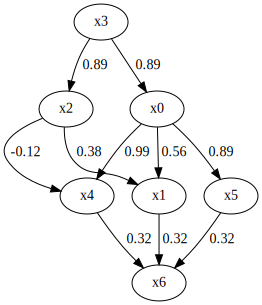

In [2]:
# 元の隣接行列は次と同じ：https://github.com/cdt15/lingam/blob/master/examples/DirectLiNGAM.ipynb

# 係数調整前の隣接行列
cg_not_adjusted = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])
# 因果順序
causal_order = [3, 0, 2, 1, 4, 5, 6]
# 各変数の分散に占める誤差項の分散の比率
ratio_list = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2]
# シンク変数のインデックス
sink_index = 6

# 係数の調整
X, causal_graph_true, e_true = generate_test_data(cg_not_adjusted, causal_order, ratio_list, size=1000)

display(make_dot(causal_graph_true))

# データ生成関数
def data_gen_direct_lingam(causal_graph, error):
    X = (np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ error.T).T
    return X, error

## 2. 実験

---- remove ----
continuous: SHD= 3.0


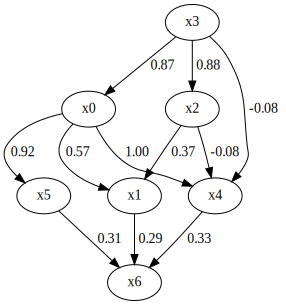

*run
before LinearRegression X_names= [3] , coef= [0.37364528]
simulation LinearRegression X_names= [3] , coef= [0.38668045]
before_after LinearRegression X_names= [3] , coef= [0.72265377]
*run shuffle
before LinearRegression X_names= [3] , coef= [0.37364528]
simulation LinearRegression X_names= [3] , coef= [0.38668045]
before_after LinearRegression X_names= [3] , coef= [0.72265377]
discrete: SHD= 5.0


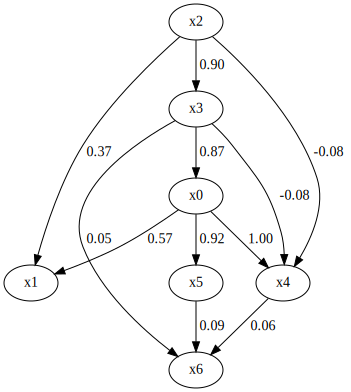

*run
before LogisticRegression X_names= [3] , coef= [[0.39983773]]
simulation LogisticRegression X_names= [3] , coef= [[2.80919554]]
before_after LogisticRegression X_names= [3] , coef= [[0.72252895]]
*run shuffle
before LogisticRegression X_names= [3] , coef= [[0.43470817]]
simulation LogisticRegression X_names= [3] , coef= [[2.80919554]]
before_after LogisticRegression X_names= [3] , coef= [[0.72252895]]
---- add ----
continuous: SHD= 1.0


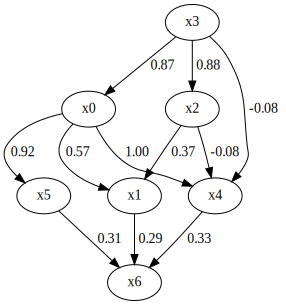

*run
before LinearRegression X_names= [3] , coef= [1.1145673]
simulation LinearRegression X_names= [3] , coef= [1.12292412]
before_after LinearRegression X_names= [3] , coef= [0.72265377]
*run shuffle
before LinearRegression X_names= [3] , coef= [1.1145673]
simulation LinearRegression X_names= [3] , coef= [1.12292412]
before_after LinearRegression X_names= [3] , coef= [0.72265377]
discrete: SHD= 4.0


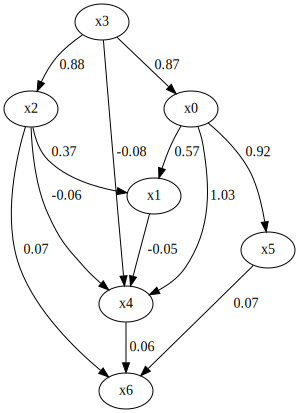

*run
before LogisticRegression X_names= [3] , coef= [[1.1414615]]
simulation LogisticRegression X_names= [3] , coef= [[4.40215832]]
before_after LogisticRegression X_names= [3] , coef= [[0.69526179]]
*run shuffle
before LogisticRegression X_names= [3] , coef= [[1.05937988]]
simulation LogisticRegression X_names= [3] , coef= [[4.40215832]]
before_after LogisticRegression X_names= [3] , coef= [[0.69526179]]
---- modify ----
continuous: SHD= 1.0


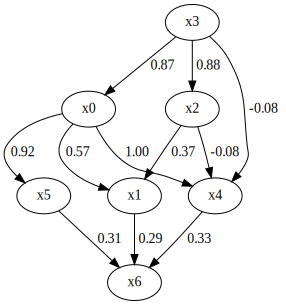

*run
before LinearRegression X_names= [3] , coef= [1.67979257]
simulation LinearRegression X_names= [3] , coef= [1.60148019]
before_after LinearRegression X_names= [3] , coef= [0.72265377]
*run shuffle
before LinearRegression X_names= [3] , coef= [1.67979257]
simulation LinearRegression X_names= [3] , coef= [1.60148019]
before_after LinearRegression X_names= [3] , coef= [0.72265377]
discrete: SHD= 3.0


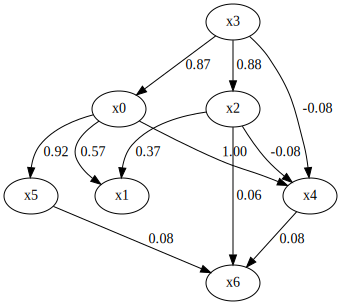

*run
before LogisticRegression X_names= [3] , coef= [[1.42837839]]
simulation LogisticRegression X_names= [3] , coef= [[3.32119504]]
before_after LogisticRegression X_names= [3] , coef= [[0.74027111]]
*run shuffle
before LogisticRegression X_names= [3] , coef= [[1.53744678]]
simulation LogisticRegression X_names= [3] , coef= [[3.32119504]]
before_after LogisticRegression X_names= [3] , coef= [[0.74027111]]


In [3]:
# 実験間で共通のデータ

# 誤差項
error = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    error.append(np.random.uniform(-a, a, size=1000))
error = np.array(error).T

# 機械学習モデル
#param_grid = {"n_estimators": [1, 2, 3]}
param_grid = {"n_estimators": [50, 100, 200]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 評価関数
eval_funcs_c = {"mse": mean_squared_error}
eval_funcs_d = {"precision": precision_score, "recall": recall_score}

# 離散変数
is_discrete = [False for _ in range(len(causal_graph_true))]
is_discrete[sink_index] = True

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x3->x2, x0->x4を削除)
causal_graph = causal_graph_true.copy()
causal_graph[2, 3] = 0
causal_graph[4, 0] = 0

test_info.append({
    "name": "remove",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x0->x2, x3->x4を追加)
causal_graph = causal_graph_true.copy()
causal_graph[2, 0] = 1
causal_graph[4, 3] = 1

test_info.append({
    "name": "add",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x2->x1を10倍に設定)
causal_graph = causal_graph_true.copy()
causal_graph[1, 2] *= 10

test_info.append({
    "name": "modify",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    print("----", info["name"], "----")
    # sinkが連続
    cdt = CausalDigitalTwin(causal_graph_true, error, data_gen_direct_lingam, sink_index)
    
    # 因果探索結果(連続)    
    shd = SHD(info["modified_causal_graph"].astype(bool).astype(int), cdt._est_adj.astype(bool).astype(int), double_for_anticausal=False)
    print("continuous: SHD=", shd)
    display(make_dot(cdt._est_adj))
    
    print("*run")
    result = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"])
    
    # sinkが連続&シャッフル
    print("*run shuffle")
    result_shuffle = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    def data_gen_direct_lingam_d(causal_graph, error):
        X_d, error_ = data_gen_direct_lingam(causal_graph, error)
        return discretize(X_d, error, sink_index), error
    cdt = CausalDigitalTwin(causal_graph_true, error, data_gen_direct_lingam_d, sink_index, is_discrete=is_discrete)
    
    # 因果探索結果(離散)
    shd = SHD(info["modified_causal_graph"].astype(bool).astype(int), cdt._est_adj.astype(bool).astype(int), double_for_anticausal=False)
    print("discrete: SHD=", shd)
    display(make_dot(cdt._est_adj))
    
    print("*run")
    result_d = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"])
    
    # sinkが離散&シャッフル
    print("*run shuffle")
    result_d_shuffle = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # 値はCausalDigitalTwin.run()の返り値に正解データを足したもの。 
    # 値： evals, predicted_values, simulated, X
    results[info["name"]] = {
        "continuous": result,
        "continuous_shuffle": result_shuffle,
        "discrete": result_d,
        "discrete_shuffle": result_d_shuffle,
    }

## 実験結果

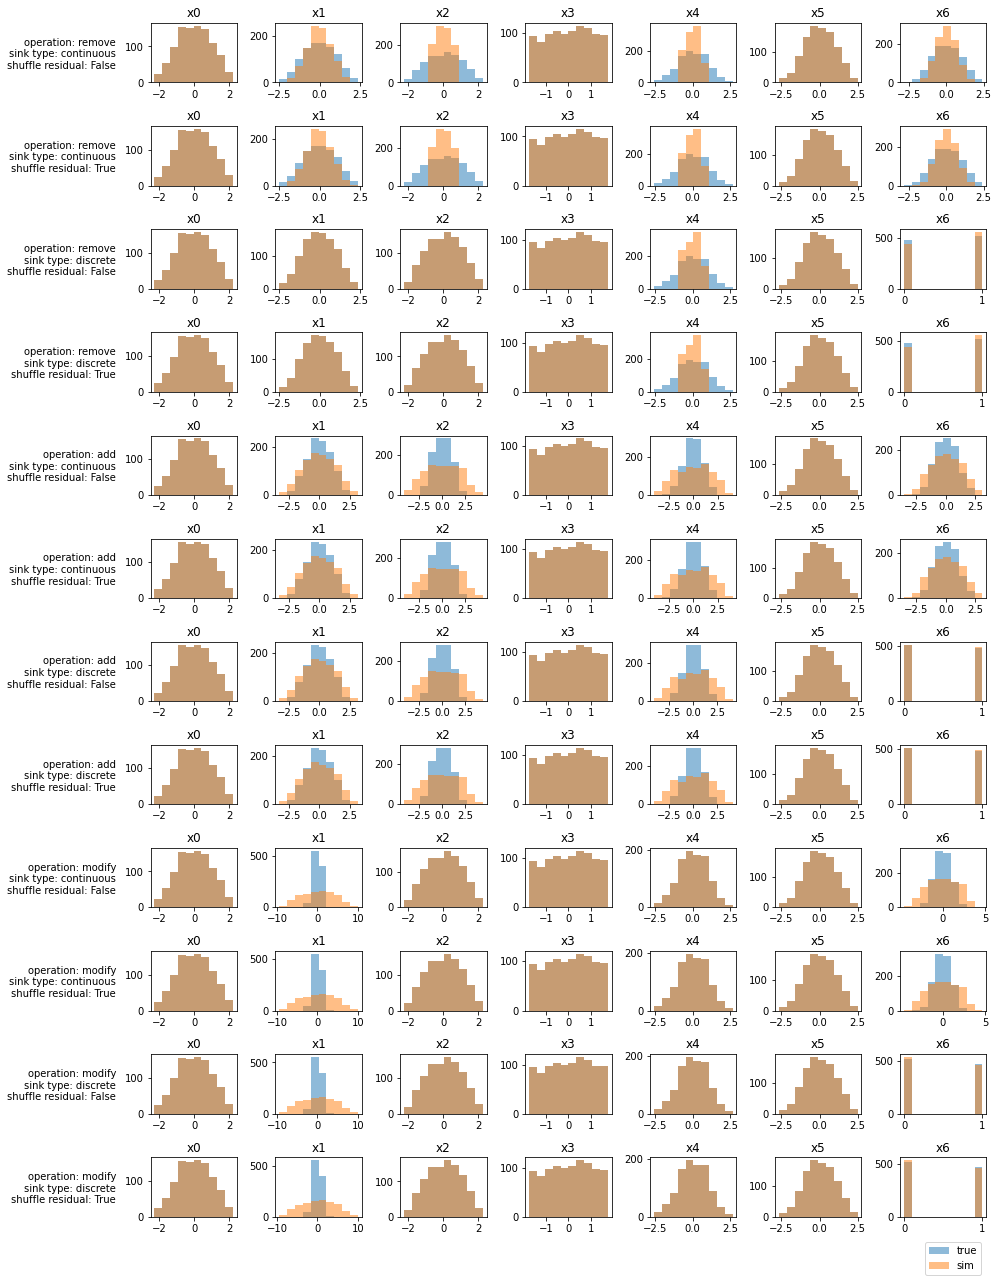

In [4]:
# 環境変化前の真のデータと環境変化後のシミュレーションデータ
n_features = len(causal_graph_true)
n_patterns = len(results) * len(results["add"])
draw_hist(n_features, n_patterns, results)

In [5]:
# シンク変数に対する機械学習モデルの精度
table_c, table_d = make_tables(results)
display(table_c.style.hide(axis="index"))
display(table_d.style.hide(axis="index"))

operation,model,shuffle error,MSE(true),MSE(sim),MSE(est)
remove,LinearRegression,False,0.304,0.304,0.420
remove,RandomForestRegressor,False,0.062,0.062,0.179
remove,LinearRegression,True,0.304,0.563,0.420
remove,RandomForestRegressor,True,0.063,0.687,0.178
add,LinearRegression,False,0.409,0.409,0.556
add,RandomForestRegressor,False,0.081,0.083,0.231
add,LinearRegression,True,0.409,2.816,0.556
add,RandomForestRegressor,True,0.086,3.055,0.230
modify,LinearRegression,False,0.650,0.656,1.527
modify,RandomForestRegressor,False,0.139,0.153,1.189


operation,model,shuffle error,Precision(true),Precision(sim),Precision(est),Recall(true),Recall(sim),Recall(est)
remove,LogisticRegression,False,0.574,0.559,0.562,0.534,0.655,0.636
remove,RandomForestClassifier,False,0.994,0.570,0.537,0.996,0.663,0.578
remove,LogisticRegression,True,0.603,0.535,0.619,0.693,0.564,0.630
remove,RandomForestClassifier,True,0.998,0.535,0.569,0.998,0.561,0.555
add,LogisticRegression,False,0.725,0.756,0.766,0.754,0.687,0.678
add,RandomForestClassifier,False,0.998,0.778,0.667,0.996,0.707,0.602
add,LogisticRegression,True,0.698,0.515,0.707,0.713,0.500,0.668
add,RandomForestClassifier,True,1.000,0.506,0.570,1.000,0.492,0.547
modify,LogisticRegression,False,0.742,0.780,0.779,0.760,0.698,0.704
modify,RandomForestClassifier,False,1.000,0.815,0.642,0.990,0.723,0.594


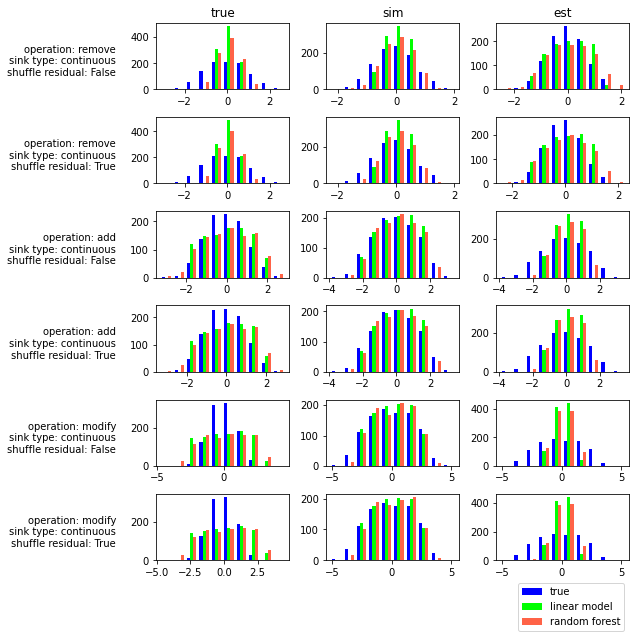

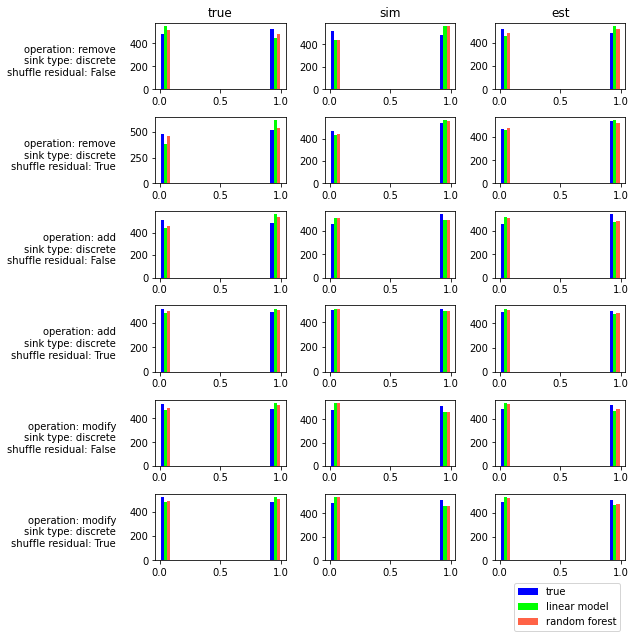

In [6]:
n_patterns = len(results) * len(results["add"])
draw_pred_hist(n_patterns, results, sink_index)